In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy 
import scipy as sc
from joblib import Parallel, delayed
from numba import jit
from tqdm.auto import tqdm
import corner
import time
import os
import sys
import emcee
from scipy.optimize import minimize

# 1

In [21]:
sc.stats.binom.ppf(q=, n=29, p=0.1)

29.0

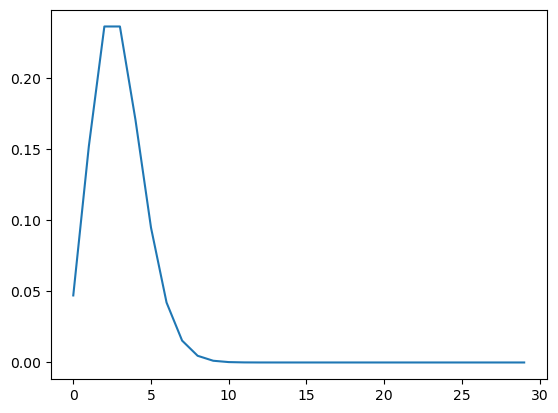

In [26]:
plt.plot(sc.stats.binom.pmf(k=np.arange(0,30), n=29, p=0.1))

0.1149868955697387 0.35700911456165313 0.21985658576888684
0.22580645161290322


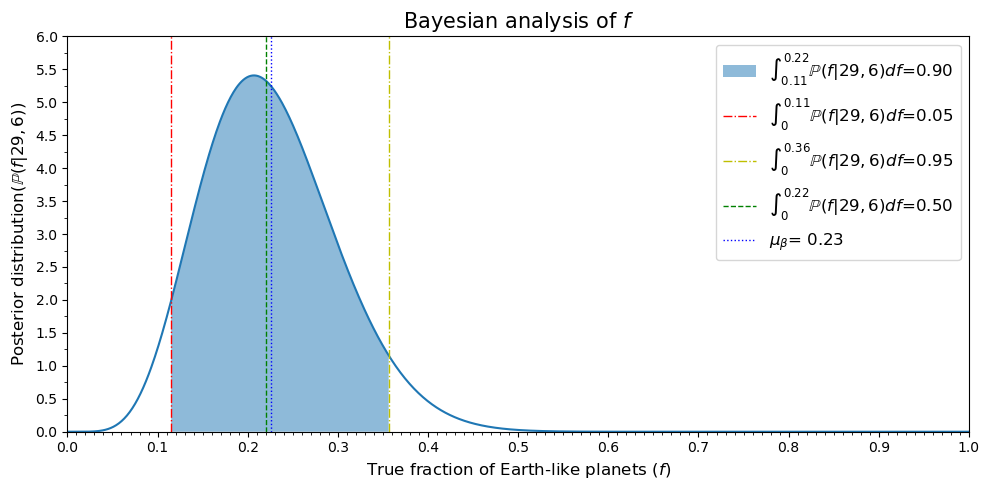

In [86]:
l=sc.stats.beta.ppf(q=0.05, a=7, b=24)
u=sc.stats.beta.ppf(q=0.95, a=7, b=24)
median=sc.stats.beta.ppf(q=0.5, a=7, b=24)
mean=sc.stats.beta.mean(a=7, b=24)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
f = np.linspace(0, 1, 1000)
Posterior = sc.stats.beta.pdf(x=f, a=7, b=24)

ax.plot(f, Posterior)

cI=r'$\int_{0.11}^{0.22}\mathbb{P}(f | 29, 6)df$'
cI_l=r'$\int_0^{0.11}\mathbb{P}(f | 29, 6)df$'
cI_u=r'$\int_0^{0.36}\mathbb{P}(f | 29, 6)df$'
cI_m=r'$\int_0^{0.22}\mathbb{P}(f | 29, 6)df$'
ax.fill_between(f, Posterior, where=(f > l) & (f < u), alpha=0.5, label=f'{cI}=0.90')
median_label = f'{median:.2f}'
mean_label = f'{mean:.2f}'
ax.axvline(x=l, color='r', linestyle='-.', label=f'{cI_l}=0.05',linewidth=1)
ax.axvline(x=u, color='y', linestyle='-.', label=f'{cI_u}=0.95',linewidth=1)
ax.axvline(x=median, color='g', linestyle='--', label=f'{cI_m}=0.50',linewidth=1)
ax.axvline(x=mean, color='b', linestyle=':', label=r'$\mu_\beta$'+f'= {mean_label}',linewidth=1)
ax.legend(fontsize=12)
ax.set_xlabel('True fraction of Earth-like planets ($f$)', fontsize=12)
ax.set_ylabel(r'Posterior distribution($\mathbb{P}(f | 29, 6)$)', fontsize=12)
ax.set_title('Bayesian analysis of $f$', fontsize=15)
ax.set_ylim(0, 6)
ax.set_xlim(0, 1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
fig.tight_layout()
fig.savefig('Bayesian_analysis_of_f.pdf')


# 2

In [2]:
def normal_values(mu, sigma, size):
    return np.random.normal(mu, sigma, size)

def samples(S):
    return [normal_values(0, 1, i) for i in range(2, S)]

num_jobs = -1
Samp = Parallel(n_jobs=num_jobs)(delayed(samples)(1000) for _ in tqdm(range(500)))

100%|██████████| 500/500 [00:07<00:00, 70.10it/s]


In [3]:
@jit(nopython=True)
def biased_variance(data):
    n=len(data)
    mean=np.sum(data)/n
    Biased_var= np.sum((data-mean)**2)/(n)
    return Biased_var
@jit(nopython=True)
def unbiased_variance(data):
    n=len(data)
    mean=np.sum(data)/n
    Unbiased_var= np.sum((data-mean)**2)/(n-1)
    return Unbiased_var

In [4]:
def normal_values(mu, sigma, size):
    return np.random.normal(mu, sigma, size)

def samples(S):
    return [normal_values(0, 1, i) for i in range(2, S)]

num_jobs = -1
Samp = Parallel(n_jobs=num_jobs)(delayed(samples)(1000) for _ in tqdm(range(500)))


@jit(nopython=True)
def biased_variance(data):
    n=len(data)
    mean=np.sum(data)/n
    Biased_var= np.sum((data-mean)**2)/(n)
    return Biased_var
@jit(nopython=True)
def unbiased_variance(data):
    n=len(data)
    mean=np.sum(data)/n
    Unbiased_var= np.sum((data-mean)**2)/(n-1)
    return Unbiased_var

Variance_biased = []
lower_biased = []
upper_biased = []


Veriance_unbiased = []
lower_unbiased = []
upper_unbiased = []

for j in range(len(Samp[0])):
    biased = []
    unbiased = []
    for i in range(len(Samp)):
        biased.append(biased_variance(Samp[i][j]))
        unbiased.append(unbiased_variance(Samp[i][j]))
    # Super_Sample.append(Val)
    Variance_biased.append(np.median(biased,axis=0))
    upper_biased.append(np.percentile(biased, 84, axis=0))
    lower_biased.append(np.percentile(biased, 16, axis=0))
    
    Veriance_unbiased.append(np.median(unbiased,axis=0))
    upper_unbiased.append(np.percentile(unbiased, 84, axis=0))
    lower_unbiased.append(np.percentile(unbiased, 16, axis=0))
    del unbiased, biased

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_51223/1809081425.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax[1].set_ylabel(f'Offset\n$(1-\sigma^2)$')


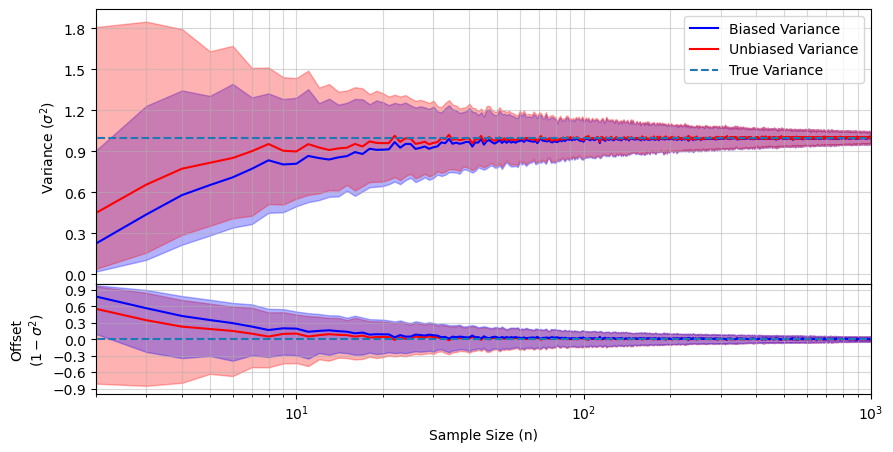

In [10]:
lengths=[len(s) for s in Samp[0]]
biased=np.array(Variance_biased)
upper_biased=np.array(upper_biased)
lower_biased=np.array(lower_biased)

upper_unbiased=np.array(upper_unbiased)
lower_unbiased=np.array(lower_unbiased)
unbiased=np.array(Veriance_unbiased)
fig, ax = plt.subplots(2, 1,height_ratios=[5,2], figsize=(10, 5),sharex=True)
ax[0].plot(lengths,biased, label='Biased Variance', color='blue')
ax[0].plot(lengths,unbiased, label='Unbiased Variance', color='red')
ax[0].fill_between(lengths, lower_biased, upper_biased, color='blue', alpha=0.3)
ax[0].fill_between(lengths, lower_unbiased, upper_unbiased, color='red', alpha=0.3)
ax[1].plot(lengths,(1-unbiased),color='red')
ax[1].plot(lengths,(1-biased),color='blue')
ax[1].fill_between(lengths, (1-upper_unbiased), (1-lower_unbiased), color='red', alpha=0.3)
ax[1].fill_between(lengths, (1-upper_biased), (1-lower_biased), color='blue', alpha=0.3)


ax[0].set_ylabel(r'Variance ($\sigma^2$)')
ax[0].hlines(1,1,10000,linestyles='dashed',label='True Variance')
ax[1].set_ylabel(f'Offset\n$(1-\sigma^2)$')
ax[0].set_xscale('log')
ax[1].set_xlabel('Sample Size (n)')
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.3))
ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.3))
ax[0].grid(which='both',alpha=0.5)
ax[1].grid(which='both',alpha=0.5)
ax[1].hlines(0,1,10000,linestyles='dashed')
ax[0].legend()
ax[1].set_ylim(-1,1)
ax[1].set_xlim(2,1000)
fig.subplots_adjust(hspace=0)



# 2b

In [110]:
Gaussian

array([1.99089814e+01, 1.32020285e+01, 1.19400661e+01, 8.90648518e+00,
       1.37266873e+01, 1.70395251e+01, 1.40100056e+01, 1.44256832e+01,
       1.37728954e+01, 1.78179657e+01, 1.84136644e+01, 1.00388495e+01,
       1.46594325e+01, 1.07494034e+01, 9.70140045e+00, 1.07158969e+01,
       1.20861585e+01, 1.32795155e+01, 3.58701149e+00, 1.07326318e+01,
       1.43886632e+01, 1.03371910e+01, 2.16979696e+01, 2.43992953e-02,
       9.28802753e+00, 1.69750875e+01, 1.49275620e+01, 1.00288842e+01,
       5.74748640e+00, 1.04138229e+01, 2.25791477e+01, 4.03823546e-01,
       1.93438211e+01, 1.23011176e+01, 1.97789838e+01, 1.85048508e+01,
       1.74338650e+01, 1.73201197e+01, 1.66839293e+01, 1.25906650e+01,
       2.22574149e+01, 1.27151270e+01, 1.49414004e+01, 1.43734367e+01,
       1.09071892e+01, 1.50951157e+01, 1.29307905e+01, 1.85521644e+01,
       1.36551573e+01, 2.14016197e+01, 1.74724098e+01, 1.86119760e+01,
       2.28073212e+01, 2.24333107e+01, 1.16355909e+01, 1.93531625e+01,
      

In [105]:
Bin_edges_1 = np.array([0,5,10,15,20,25,30])
Bin_edges_2 = np.array([-1,3,7,11,15,19,23,27,31])

Gaussian= np.genfromtxt('Gaussian.txt')

C_1, Bin_edges_1 = np.histogram(Gaussian, bins=Bin_edges_1)
C_2, Bin_edges_2 = np.histogram(Gaussian, bins=Bin_edges_2)


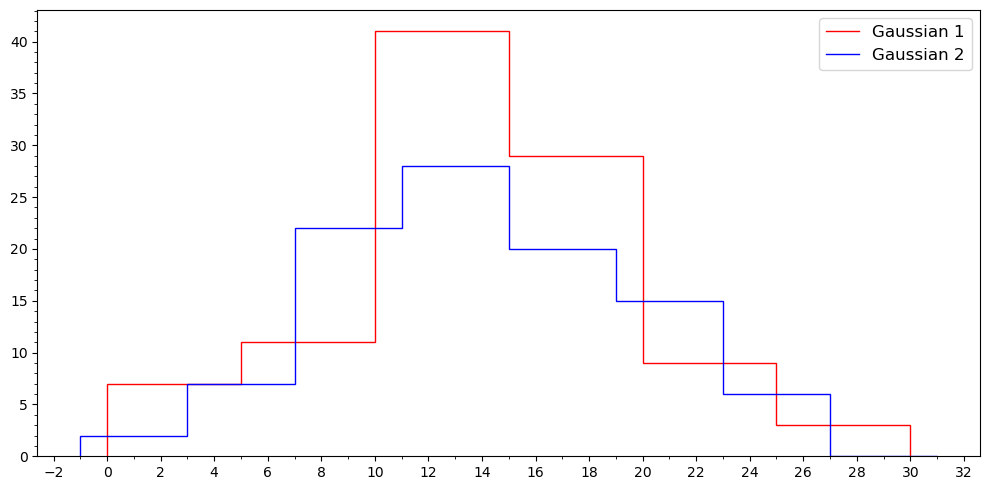

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.stairs(C_1, edges=Bin_edges_1,label='Gaussian 1',alpha=1, color='red',edgecolor='red')
ax.stairs(C_2, edges=Bin_edges_2,label='Gaussian 2',alpha=1, color='blue',edgecolor='blue')
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.legend(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
# ax.grid(which='both',alpha=0.5)
plt.tight_layout()  
plt.savefig('Histogram_2.pdf')

In [107]:
Bin_mid_1 = (Bin_edges_1[1:] + Bin_edges_1[:-1]) / 2
Bin_mid_2 = (Bin_edges_2[1:] + Bin_edges_2[:-1]) / 2

In [109]:
def Gaussian_function(A, mu, sigma, x):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def Chi_2_Gaussian_function(theta, y,x):
    Estimate=Gaussian_function(*theta, x)
    return np.sum(((y - Estimate) ** 2)/Estimate)


from scipy.optimize import least_squares
initial=[10, 12, 5]
bounds=([10, 5, 1], [50, 25, 10])
fit_1=least_squares(Chi_2_Gaussian_function, x0=initial, args=(C_1, Bin_mid_1),bounds=bounds)
fit_2=least_squares(Chi_2_Gaussian_function, x0=initial, args=(C_2, Bin_mid_2),bounds=bounds)

print(fit_1.x)
print(fit_2.x)


[35.94464386 13.85783198  5.77573855]
[27.93392344 14.08387148  5.83151622]


In [24]:
MC_number=10000

def monte_carlo_simulation(FIT, Center, counts, MC_number):
    A, mu, sigma = FIT.x
    bounds=([0.1,mu-5,sigma-5],[A+20,mu+5,sigma+5])
    Distribution={}
    def MC():
        New_Counts= counts + np.random.normal(0, np.sqrt(counts), size=len(counts))
        results=least_squares(Chi_2_Gaussian_function, x0=FIT.x, args=(New_Counts, Center),bounds=bounds)
        return results.x
    
    Theta=Parallel(n_jobs=-1)(delayed(MC)() for _ in tqdm(range(MC_number)))
    Theta=np.array(Theta)
    for i in range(len((FIT.x))):
        Distribution[f'X{i}']=Theta[:,i]
        
    return Distribution

Distribution_1=monte_carlo_simulation(fit_1, Bin_mid_1, C_1, MC_number)

Distribution_2=monte_carlo_simulation(fit_2, Bin_mid_2, C_2, MC_number)
    
    















































































































































































































































































































































































100%|██████████| 10000/10000 [01:18<00:00, 127.29it/s]










































































































































































  6%|▋         | 635/10000 [14:35<3:35:14,  1.38s/it]









































100%|██████████| 10000/10000 [00:52<00:00, 190.94it/s]


In [6]:
fig,ax = plt.subplots(1, len(Distribution_1), figsize=(15, 5))

median_1 = {key: np.median(Distribution_1[key]) for key in Distribution_1.keys()}
median_2 = {key: np.median(Distribution_2[key]) for key in Distribution_2.keys()}

upper_1 = {key: np.percentile(Distribution_1[key], 84) for key in Distribution_1.keys()}
upper_2 = {key: np.percentile(Distribution_2[key], 84) for key in Distribution_2.keys()}

lower_1 = {key: np.percentile(Distribution_1[key], 16) for key in Distribution_1.keys()}
lower_2 = {key: np.percentile(Distribution_2[key], 16) for key in Distribution_2.keys()}


NameError: name 'Distribution_1' is not defined

/tmp/ipykernel_60552/382899480.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels([0,0,50,100,150,200,250,300,350])


Text(0, 0.5, 'Counts')

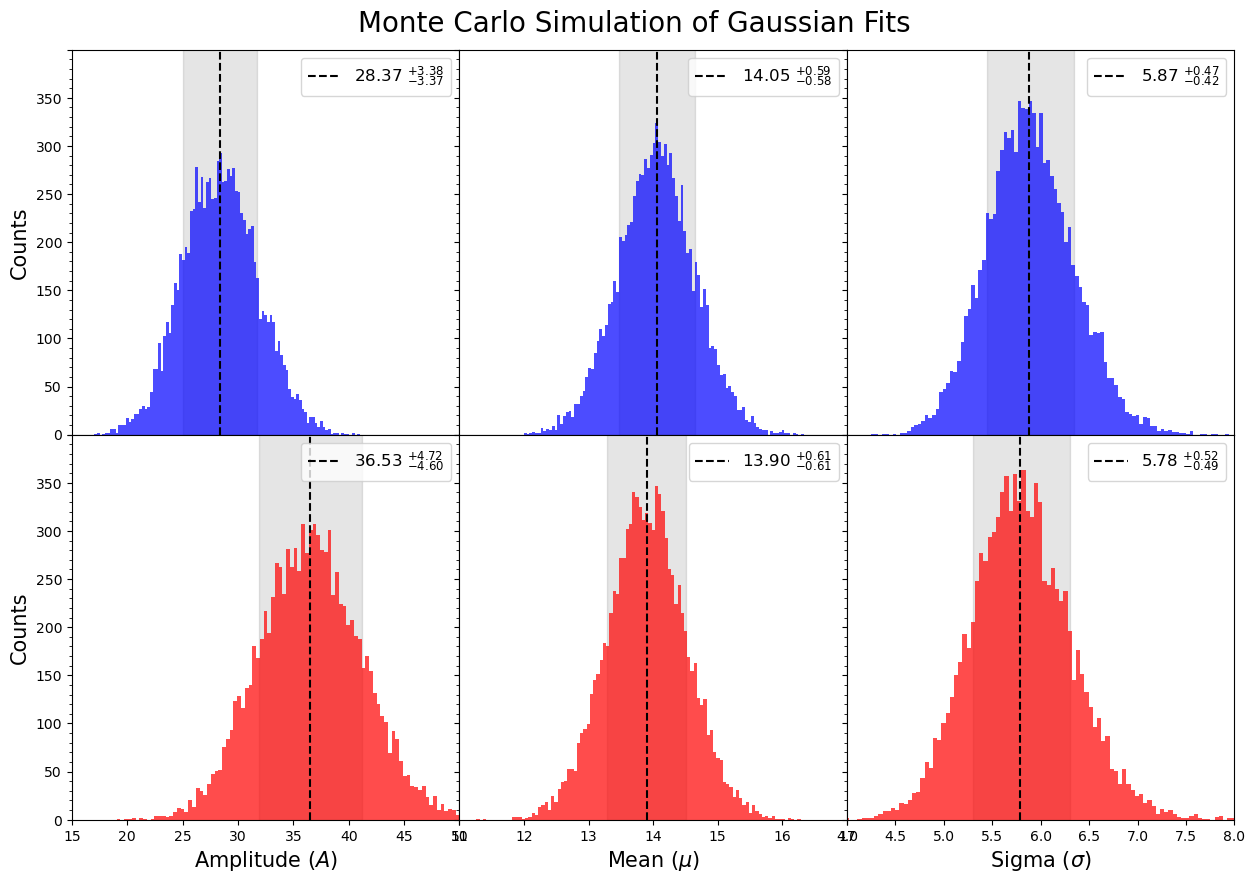

In [93]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10),sharex=False,sharey=True)
ax = ax.flatten()  # Flatten the 2D array of axes for easier indexing

for i, key in enumerate(Distribution_2.keys()):
    value_to_label=f'{median_2[key]:.2f} $^{{+{upper_2[key]-median_2[key]:.2f}}}_{{-{median_2[key]-lower_2[key]:.2f}}}$'
    ax[i].vlines(median_2[key], 0, 10000, color='black', label=f'{value_to_label}', linestyle='dashed')
    ax[i].fill_betweenx([0, 10000], lower_2[key], upper_2[key], color='black', alpha=0.1)
    ax[i].hist(Distribution_2[key], bins=100, color='blue', alpha=0.7)#, label='Bin Edge 2')
    ax[i].set_ylim(0, 400)
    ax[i].legend(fontsize=12,loc='best')
    ax[i].set_xticks([])
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(50))
    ax[i].yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax[i].set_yticklabels([0,0,50,100,150,200,250,300,350])
    
for i, key in enumerate(Distribution_1.keys()):
    i=i+3
    value_to_label=f'{median_1[key]:.2f} $^{{+{upper_1[key]-median_1[key]:.2f}}}_{{-{median_1[key]-lower_1[key]:.2f}}}$'
    ax[i].fill_betweenx([0, 10000], lower_1[key], upper_1[key], color='black', alpha=0.1)
    ax[i].hist(Distribution_1[key], bins=100, color='red', alpha=0.7)#, label='Bin Edge 1')
    ax[i].vlines(median_1[key], 0, 100000, color='black', label=f'{value_to_label}', linestyle='dashed')
    ax[i].set_ylim(0, 400)
    ax[i].legend(fontsize=12,loc='best')


ax[2].set_xlim(4,8)
ax[1].set_xlim(11,17)
ax[0].set_xlim(15,50)
ax[2+3].set_xlim(4,8)
ax[1+3].set_xlim(11,17)
ax[0+3].set_xlim(15,50)
ax[3].set_xlabel(r'Amplitude ($A$)', fontsize=15)
ax[4].set_xlabel(r'Mean ($\mu$)',fontsize=15)
ax[5].set_xlabel(r'Sigma ($\sigma$)',fontsize=15)
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Monte Carlo Simulation of Gaussian Fits', fontsize=20, y=0.92)
ax[0].set_ylabel('Counts',fontsize=15)
ax[3].set_ylabel('Counts',fontsize=15)

## 2c

In [ ]:
def Log_likelihood_2c(theta,Data):
    Sigma,mu = theta
    
    Log_likelihood= np.sum(sc.stats.norm.logpdf(Data, loc=mu, scale=Sigma))
    return Log_likelihood

def Log_prior_2c(theta):
    Sigma,mu = theta
    if 4 < Sigma < 8 and 12 < mu < 16:
        return 0
    return -np.inf

def Log_posterior_2c(theta, Data):
    return Log_prior_2c(theta) + Log_likelihood_2c(theta,Data)
space=1e-3
Sigma=np.arange(5,7,space)
mu=np.arange(13,15,space)

Sigma_mesh,mu_mesh=np.meshgrid(Sigma,mu)

log_likelihood_2c = np.zeros((np.shape(Sigma_mesh)))

for j in tqdm(range(len(Sigma_mesh))):
    for i in range(len(mu_mesh)):
        log_likelihood_2c[i,j] = Log_posterior_2c((Sigma_mesh[i,j], mu_mesh[i,j]),Gaussian)
Probablitity_2c=(10**log_likelihood_2c)/np.sum(10**log_likelihood_2c) # NORMALIZING

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_107537/2407154662.py:47: SyntaxWarning: invalid escape sequence '\m'
  ax.scatter(Sigma_mesh[max_A_index], mu_mesh[max_A_index], color='red', marker='x', label=f'$\mu=${MU_value}\n$\sigma=${Sigma_value}')
/tmp/ipykernel_107537/2407154662.py:47: SyntaxWarning: invalid escape sequence '\s'
  ax.scatter(Sigma_mesh[max_A_index], mu_mesh[max_A_index], color='red', marker='x', label=f'$\mu=${MU_value}\n$\sigma=${Sigma_value}')
/tmp/ipykernel_107537/2407154662.py:63: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Standard Deviation ($\sigma$)', fontsize=15)
/tmp/i

5.406000000000136 5.935000000000312


/tmp/ipykernel_107537/2407154662.py:48: UserWarning: The following kwargs were not used by contour: 'linestyle', 'lw'
  ax.contour(Sigma_mesh, mu_mesh, LOG, levels=[percentile_90], colors='black', linestyle='-', lw=0.2, alpha=1)


5.62800000000021 14.104999999999388 14.10099999999939


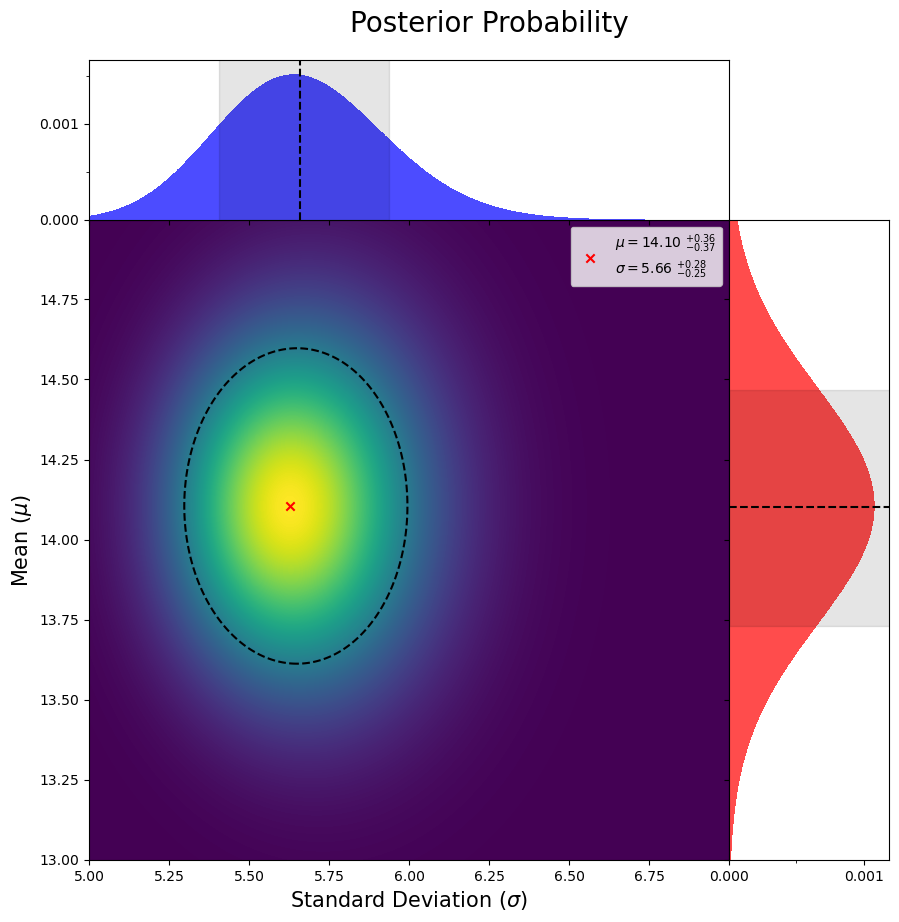

In [219]:
def imshow_hist(Like, ax, ax_histx, ax_histy):
    ax.imshow((Like), cmap='viridis', origin='lower', extent=(np.min(Sigma), np.max(Sigma), np.min(mu), np.max(mu)))
    max_A_index = np.unravel_index(np.argmax(Like), Like.shape)

    marginal_mu = np.sum(Like, axis=1)
    marginal_sigma = np.sum(Like, axis=0) 
    marginal_mu /= np.sum(marginal_mu)  # Normalize
    marginal_sigma /= np.sum(marginal_sigma)  # Normalize
    bins_mu=len(marginal_mu)
    bins_alpha=len(marginal_sigma)
    median_mu = np.where(np.isclose(np.cumsum(marginal_mu),0.5,atol=1e-3))[0][0]

    median_sigma = np.where(np.isclose(np.cumsum(marginal_sigma),0.5, atol=1e-3))[0][0]
    lower_mu = np.where(np.isclose(np.cumsum(marginal_mu),0.15865,atol=1e-3))[0][0]
    upper_mu = np.where(np.isclose(np.cumsum(marginal_mu),0.84135,atol=1e-3))[0][0]
    lower_sigma = np.where(np.isclose(np.cumsum(marginal_sigma),0.15865,atol=1e-3))[0][0]
    upper_sigma = np.where(np.isclose(np.cumsum(marginal_sigma),0.84135,atol=1e-3))[0][0]
    print(Sigma[lower_sigma],Sigma[upper_sigma])
    ax_histx.hist(np.linspace(np.min(Sigma), np.max(Sigma), len(marginal_sigma)), weights=marginal_sigma, bins=bins_alpha, alpha=0.7, color='blue')

    ax_histx.axvline(x=Sigma[median_sigma], color='black', linestyle='dashed', label=f'Median={Sigma[median_sigma]:.2f}')
    ax_histx.fill_between([Sigma[lower_sigma], Sigma[upper_sigma]], 0, np.max(marginal_sigma)+0.1, color='black', alpha=0.1)
    ax_histx.set_xlim(np.min(Sigma), np.max(Sigma))
    ax_histx.set_ylim(0, np.max(marginal_sigma)*(1.1))
    ax_histx.yaxis.set_major_locator(plt.MultipleLocator(0.001))
    ax_histx.yaxis.set_minor_locator(plt.MultipleLocator(0.0005))
    # ax_histx.yaxis.set_minor_locator(plt.MultipleLocator(0.001))
    ax_histy.hist(np.linspace(np.min(mu), np.max(mu), len(marginal_mu)),orientation='horizontal', weights=marginal_mu, bins=bins_mu, alpha=0.7, color='red')
    ax_histy.axhline(y=mu[median_mu], color='black', linestyle='dashed', label=f'Median={mu[median_mu]:.2f}')
    ax_histy.fill_betweenx([mu[lower_mu], mu[upper_mu]], 0, np.max(marginal_sigma)+0.1, color='black', alpha=0.1)
    ax_histy.set_ylim(np.min(mu), np.max(mu))
    ax_histy.set_xlim(0, np.max(marginal_mu)*(1.1))
    ax_histy.xaxis.set_major_locator(plt.MultipleLocator(0.001))
    ax_histy.xaxis.set_minor_locator(plt.MultipleLocator(0.0005))
    
    # Set limits for axes if needed
    ax_histx.set_xlim(np.min(Sigma), np.max(Sigma))  # Change as necessary
    ax_histy.set_ylim(np.min(mu), np.max(mu))  # Change as necessary
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    LOG=np.log10(Like)
    percentile_90 = LOG.max() - 0.5 * sc.stats.chi2.ppf(q=(1 - 0.6827), df=2)
    MU_value=f'{mu[median_mu]:.2f} $^{{+{mu[upper_mu]-mu[median_mu]:.2f}}}_{{-{mu[median_mu]-mu[lower_mu]:.2f}}}$'
    Sigma_value=f'{Sigma[median_sigma]:.2f} $^{{+{Sigma[upper_sigma]-Sigma[median_sigma]:.2f}}}_{{-{Sigma[median_sigma]-Sigma[lower_sigma]:.2f}}}$'
    
    ax.scatter(Sigma_mesh[max_A_index], mu_mesh[max_A_index], color='red', marker='x', label=f'$\mu=${MU_value}\n$\sigma=${Sigma_value}')
    ax.contour(Sigma_mesh, mu_mesh, LOG, levels=[percentile_90], colors='black', linestyle='-', lw=0.2, alpha=1)
    ax.legend()
    print(Sigma_mesh[max_A_index],mu_mesh[max_A_index],mu[median_mu])
    return marginal_mu, marginal_sigma



    
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.0, hspace=0.0)

# Create subplots
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])
ax.set_xlabel('Standard Deviation ($\sigma$)', fontsize=15)
ax.set_ylabel('Mean ($\mu$)', fontsize=15)
fig.suptitle('Posterior Probability',  fontsize=20, y=0.95)

# Draw the scatter plot and marginals
muu,siggg=imshow_hist(Probablitity_2c, ax, ax_histx, ax_histy)
fig.subplots_adjust(hspace=0, wspace=0)
# Show the plot
plt.show()

In [141]:
mu

array([13.   , 13.001, 13.002, ..., 14.997, 14.998, 14.999])

In [143]:
np.max(mu)

14.998999999998892

In [160]:
marginal_mu = np.sum(Probablitity_2c, axis=0)  # Sum over sigma (y-axis)


flat_mu=marginal_mu/ np.sum(marginal_mu)  # Normalize the distribution

In [161]:
C=np.cumsum(flat_mu)

In [173]:
mu[np.where(np.isclose(C, 0.5, atol=1e-3))[0]][0]


13.659999999999634

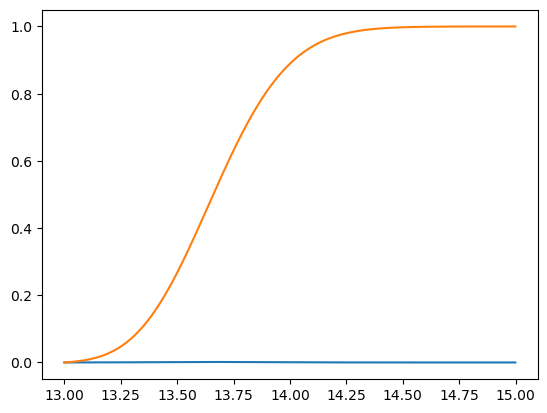

In [162]:
plt.plot(mu, flat_mu)
plt.plot(mu, C)

# 3

## 3a

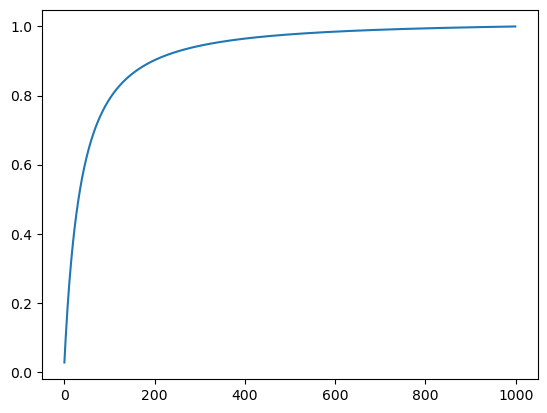

In [121]:
plt.plot(np.cumsum(IMF_binned(m)))

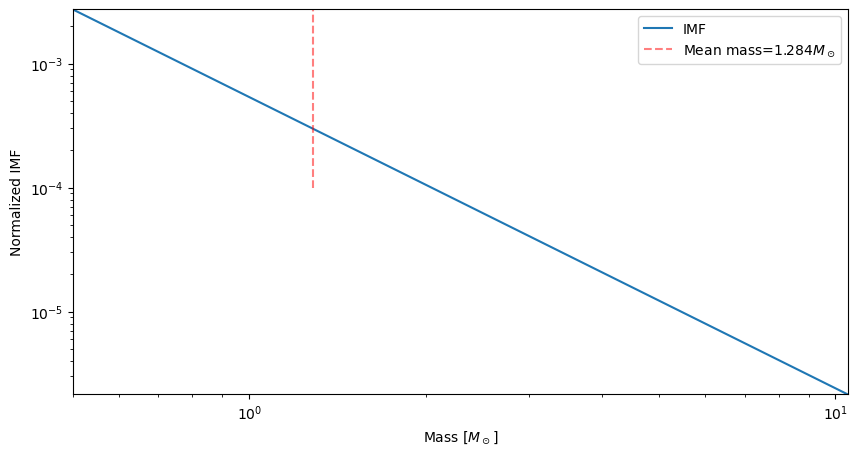

In [130]:


def IMF_binned(m_bins, alpha=-2.35):
    # Calculate the IMF value at each bin center
    Law = m_bins**alpha
    bin_widths=m_bins[1]-m_bins[0]
    normalization = np.sum(Law)
    # Normalize the IMF by dividing by the normalization factor
    return Law / normalization

m=np.linspace(0.5,10.5,10000)

def mean_mass(m,IMF):
    
    return np.sum(m*IMF(m))

fig , ax = plt.subplots(figsize=(10,5))
ax.plot(m,IMF_binned(m),label='IMF')
ax.loglog()
ax.set_xlabel(r'Mass [$M_\odot$]')
ax.set_ylabel('Normalized IMF')
ax.vlines(mean_mass(m,IMF_binned),1e-4,1e3,label=f'Mean mass={mean_mass(m,IMF_binned):.3f}'+r'$M_\odot$',color='r',linestyle='--',alpha=0.5)
ax.set_ylim(np.min(IMF_binned(m)),np.max(IMF_binned(m)))
ax.set_xlim(np.min(m),np.max(m))
ax.legend()

## 3b

/usr/lib/python3/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/tmp/ipykernel_10317/1237029037.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set_ylim(0, 1)


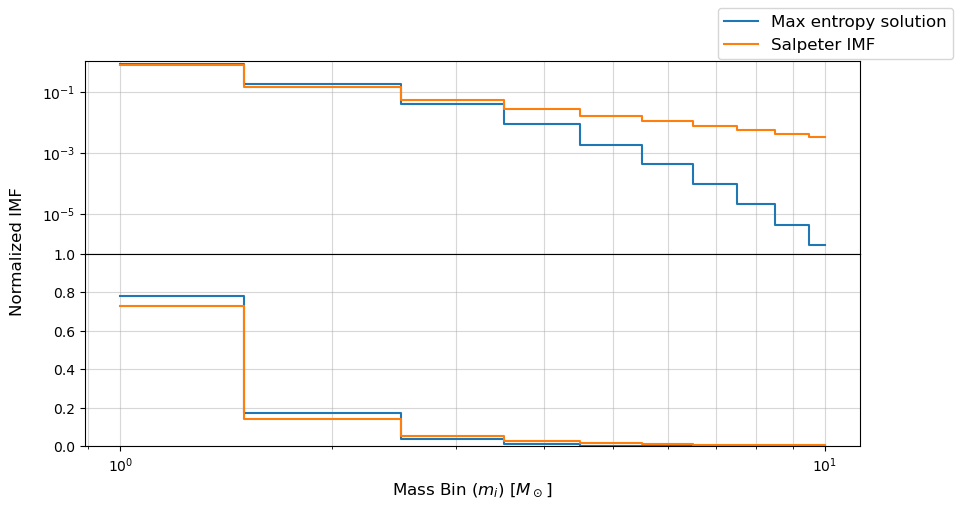

In [194]:
mbin =np.array([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]) # bin edges
cbin = (mbin[1:] + mbin[:-1]) / 2 # bin centers
P0 = np.ones(len(cbin))/len(cbin) # initial guess
bounds = [(1e-15,0.999) for k in range(len(cbin))] # probablity bounds
Observed_mean = 1.285 # observed mean mass

def n_entropy(P): # negative entropy
    return sum(P*np.log(P))

# mean mass constraint 
mass_constr = lambda P : -(np.sum(P*cbin)-Observed_mean)
# normality constaint
normality_constr = lambda P: -(np.sum(P)-1)
# constaints go in as a dictionary
Constraints = [
    {'type': 'eq', 'fun': mass_constr },
    {'type': 'eq','fun': normality_constr}
]

result = sc.optimize.minimize(n_entropy, P0, method='SLSQP', bounds=bounds, constraints=Constraints)
fig, ax = plt.subplots(2, 1, figsize=(10, 5),sharex=True)
bin_width=mbin[1]-mbin[0]
ax[0].step(cbin, result.x/bin_width, where='mid',label='Max entropy solution')

# Define the Salpeter IMF function
def salpeter_IMF(m):
    return m**-2.35 / np.sum(m**-2.35)

m = np.linspace(1, 10, 10)
ax[0].step(m, salpeter_IMF(m), label='Salpeter IMF',where='mid')
ax[1].set_xlabel(r'Mass Bin ($m_i$) [$M_\odot$]', fontsize=12)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[1].step(cbin, result.x, where='mid')
ax[1].step(cbin, salpeter_IMF(m), where='mid')
ax[0].xaxis.set_minor_locator(FixedLocator([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax[1].grid(which='both',alpha=0.5)
ax[0].grid(which='both',alpha=0.5)
# ax[0].set_ylabel(r'$\log_{10}($IMF$)$', fontsize=12)
ax[0].loglog()
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].set_xscale('log')
fig.supylabel('Normalized IMF', fontsize=12, x=0.05)
fig.legend(fontsize=12, loc='upper right')
fig.subplots_adjust(hspace=0)
plt.savefig('Max_entropy_solution.pdf')



In [235]:
data={r'Mass Bin ($m_i$) $[M_\odot]$':cbin,r'Entropy Maximized IMF $(\mathbb{P}(m_i)$)':result.x,'Salpeter IMF':salpeter_IMF(cbin)}

In [236]:
import pandas as pd

In [237]:
panda=pd.DataFrame(data)

In [263]:
# panda.style.format({'Entropy Maximized IMF $(\mathbb{P}(m_i)$)': "{:.2f}"})

panda.style.format({'Mass Bin ($m_i$) $[M_\odot]$': "{:.0f}"})


<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:3: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_10317/908312319.py:3: SyntaxWarning: invalid escape sequence '\o'
  panda.style.format({'Mass Bin ($m_i$) $[M_\odot]$': "{:.0f}"})


,Mass Bin ($m_i$) $[M_\odot]$,Entropy Maximized IMF $(\mathbb{P}(m_i)$),Salpeter IMF
0,1,0.778185,0.726779
1,2,0.172612,0.142555
2,3,0.038303,0.054975
3,4,0.008508,0.027962
4,5,0.001853,0.016551
5,6,0.000421,0.010783
6,7,0.000092,0.007506
7,8,0.000020,0.005485
8,9,0.000004,0.004158
9,10,0.000001,0.003246


In [265]:
print(panda.to_latex(index=False,longtable=True,escape=False, caption='Maximized Entropy IMF and Salpeter IMF',label='tab:Maximized_Entropy_IMF',bold_rows=True,))

\begin{longtable}{rrr}
\caption{Maximized Entropy IMF and Salpeter IMF} \label{tab:Maximized_Entropy_IMF} \\
\toprule
Mass Bin ($m_i$) $[M_\odot]$ & Entropy Maximized IMF $(\mathbb{P}(m_i)$) & Salpeter IMF \\
\midrule
\endfirsthead
\caption[]{Maximized Entropy IMF and Salpeter IMF} \\
\toprule
Mass Bin ($m_i$) $[M_\odot]$ & Entropy Maximized IMF $(\mathbb{P}(m_i)$) & Salpeter IMF \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
1.000000 & 0.778185 & 0.726779 \\
2.000000 & 0.172612 & 0.142555 \\
3.000000 & 0.038303 & 0.054975 \\
4.000000 & 0.008508 & 0.027962 \\
5.000000 & 0.001853 & 0.016551 \\
6.000000 & 0.000421 & 0.010783 \\
7.000000 & 0.000092 & 0.007506 \\
8.000000 & 0.000020 & 0.005485 \\
9.000000 & 0.000004 & 0.004158 \\
10.000000 & 0.000001 & 0.003246 \\
\end{longtable}



# 4

In [4]:
import astropy.table


def lambda_i(A,B,xi,sigma,mu):
    l=B+((A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((xi-mu)**2)/(2*sigma**2)))
    return l

# Data_4 = ascii.read('poisson.csv')
Data_4 =  astropy.table.Table.read('poisson.csv', format='ascii')
size = np.sum(Data_4['O_i'])

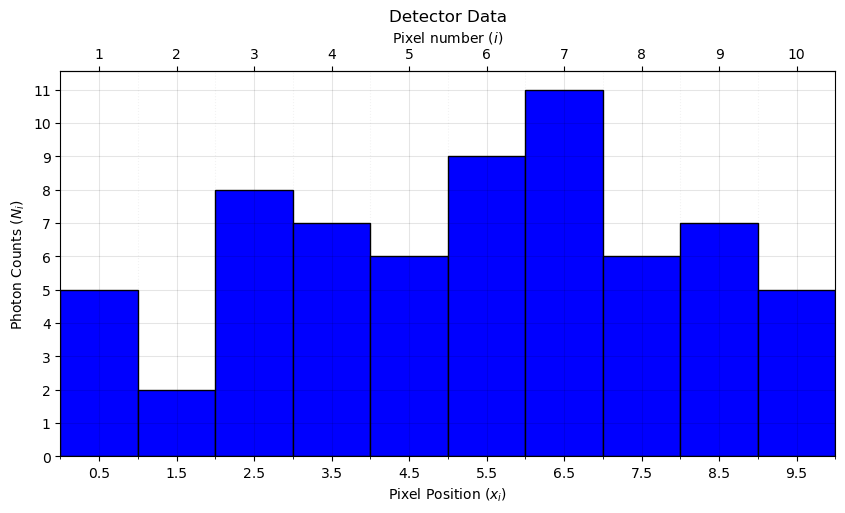

In [5]:
from matplotlib.ticker import FixedLocator


fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(Data_4['x_i'], Data_4['O_i'], color='b', alpha=1, edgecolor='black', width=1)
ax.set_xlabel('Pixel Position ($x_i$)')
ax.set_ylabel('Photon Counts ($N_i$)')
ax.set_title('Detector Data')

ax.xaxis.set_major_locator(FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]))
ax.xaxis.set_minor_locator(FixedLocator([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
ax.yaxis.set_major_locator(FixedLocator([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12]))
secax = ax.secondary_xaxis('top', functions=(lambda x: x+0.5, lambda x: x))
secax.xaxis.set_major_locator(FixedLocator([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
secax.set_xlabel('Pixel number ($i$)')
ax.set_xlim(0, 10)
ax.grid(which='major', linestyle='-', alpha=0.1, color='black')
ax.grid(which='minor', linestyle=':', alpha=0.05, color='black')


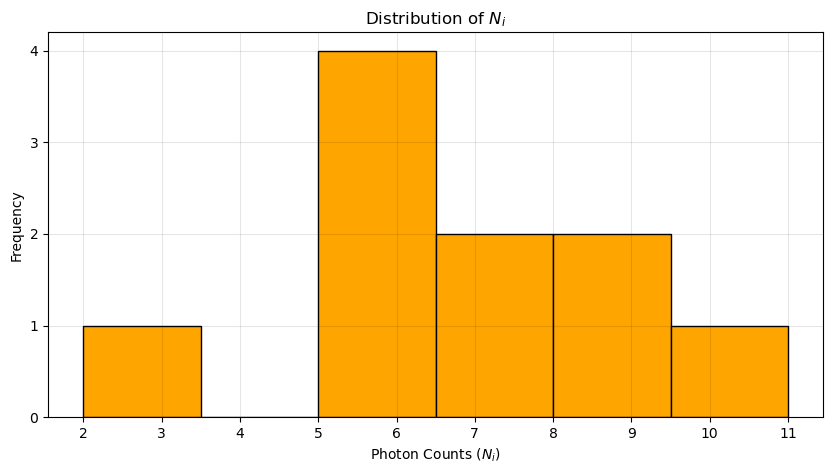

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
#distribution of N_i
ax.hist(Data_4['O_i'], bins=6, color='orange', alpha=1, edgecolor='black')
ax.set_xlabel('Photon Counts ($N_i$)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of $N_i$')
ax.grid(which='major', linestyle='-', alpha=0.1, color='black')
ax.grid(which='minor', linestyle=':', alpha=0.05, color='black')
ax.yaxis.set_major_locator(FixedLocator([0, 1, 2,3,4,5]))
ax.xaxis.set_major_locator(FixedLocator([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))

In [8]:
mu_a=5.3
sigma_a=1.2

space=(1e-2)
max_A=50
max_B=50


A_grid_a=np.linspace(0,max_A,10000)
B_grid_a=np.linspace(0,max_B,10000)

xi=Data_4['x_i']
N_i=Data_4['O_i']


def lambda_i(A,B,xi,sigma,mu):
    l=B+((A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((xi-mu)**2)/(2*sigma**2)))
    return l


## 4a

In [ ]:



from scipy.optimize import minimize

def loglikelihood_a(theta,xi,N_i):
    A,B=theta
    lam=lambda_i(A,B,xi,sigma_a,mu_a)
    return np.sum(sc.stats.poisson.logpmf(N_i, lam))


def log_prior_a(theta,xi,N_i):
    A,B=theta
    if 0 < A < max_A and 0 < B < max_B:
        return 0.0
    return -np.inf

def log_probability_a(theta,xi,N_i):
    lp = log_prior_a(theta,xi,N_i)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood_a(theta,xi,N_i)

# start the walked around the maximum likelihood as a gaussian ball
pos_a= np.array([12.26,5.37])+1e-2 * np.random.randn(128, 2)
nwalkers_a, ndim_a = pos_a.shape
from multiprocessing import Pool
with Pool() as pool:
    sampler_a = emcee.EnsembleSampler(nwalkers_a, ndim_a, log_probability_a, args=(xi,N_i),pool=pool)
    run_a=sampler_a.run_mcmc(pos_a, int(1e4), progress=True)


Text(0.5, 0, 'step number')

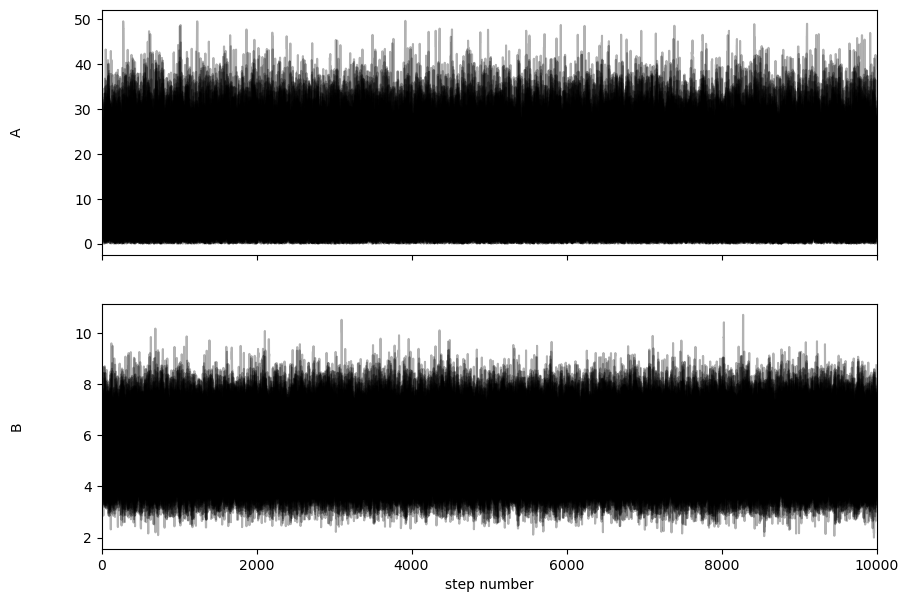

In [9]:
fig, axes = plt.subplots(ndim_a, figsize=(10, 7), sharex=True)
samples_a = sampler_a.get_chain()
labels = ["A", "B"]
for i in range(ndim_a):
    ax = axes[i]
    ax.plot(samples_a[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_a))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


In [10]:
tau_a = sampler_a.get_autocorr_time()
print(tau_a)

[31.24037461 31.58603247]


(1267200, 2)


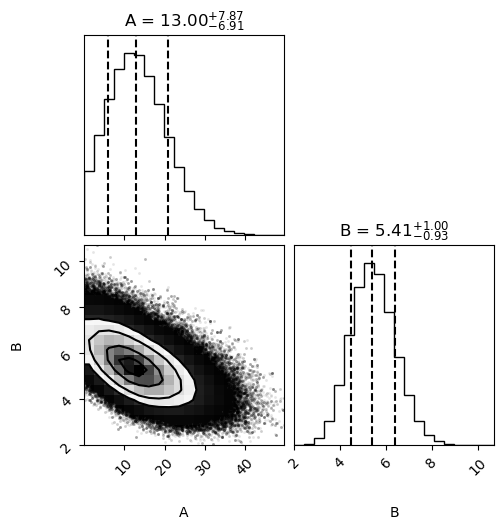

In [11]:
flat_samples_a = sampler_a.get_chain(discard=100, thin=1, flat=True)
print(flat_samples_a.shape)
fig = corner.corner(
    flat_samples_a, labels=labels,quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

## 4b

$p(A,B,\mu|x_i,N_i,\sigma)\propto p(A,B,\mu)p(N_i|A,B,\mu,\sigma) $

In [18]:
from scipy.optimize import minimize



def loglikelihood_b(theta,xi,N_i):
    A,B,mu=theta
    lam=lambda_i(A,B,xi,sigma_a,mu)
    return np.sum(sc.stats.poisson.logpmf(N_i, lam))


def log_prior_b(theta,xi,N_i):
    A,B,mu=theta
    if 0 < A < max_A and 0 < B < max_B and 0 < mu < 10:
        return 0.0
    return -np.inf

def log_probability(theta,xi,N_i):
    lp = log_prior_b(theta,xi,N_i)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood_b(theta,xi,N_i)

# start the walked around the maximum likelihood as a gaussian ball
pos= np.array([12.26,5.37,1])+1e-2 * np.random.randn(128, 3)
nwalkers, ndim = pos.shape


from multiprocessing import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xi,N_i))
    run=sampler.run_mcmc(pos, int(1e4), progress=True)




100%|██████████| 10000/10000 [03:12<00:00, 51.89it/s]


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1013/2307031321.py:3: SyntaxWarning: invalid escape sequence '\m'
  labels = ["A", "B", f"$\mu$"]


Text(0.5, 0, 'step number')

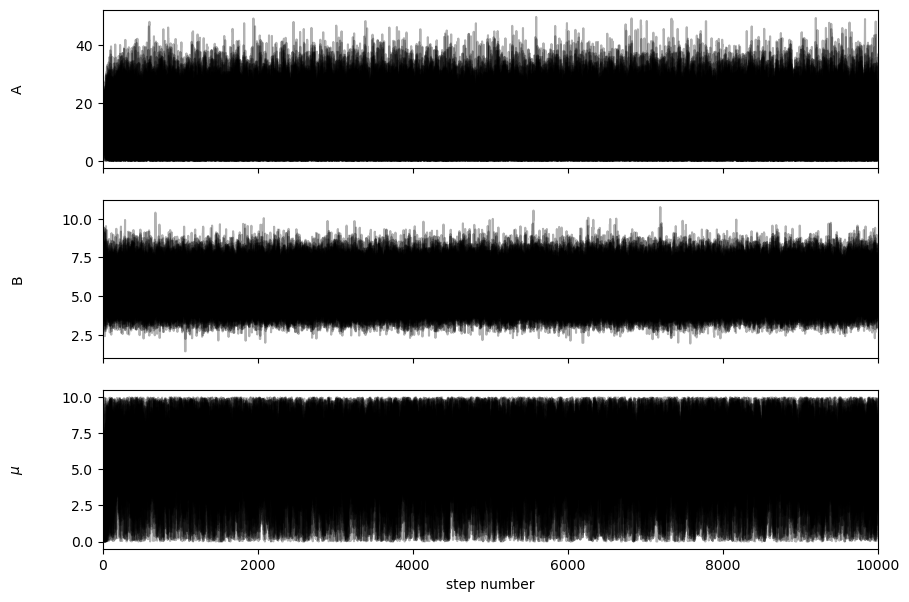

In [19]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B", f"$\mu$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [20]:
tau = sampler.get_autocorr_time()
print(tau)

[43.05635527 42.56919124 45.86385861]


(126720, 3)


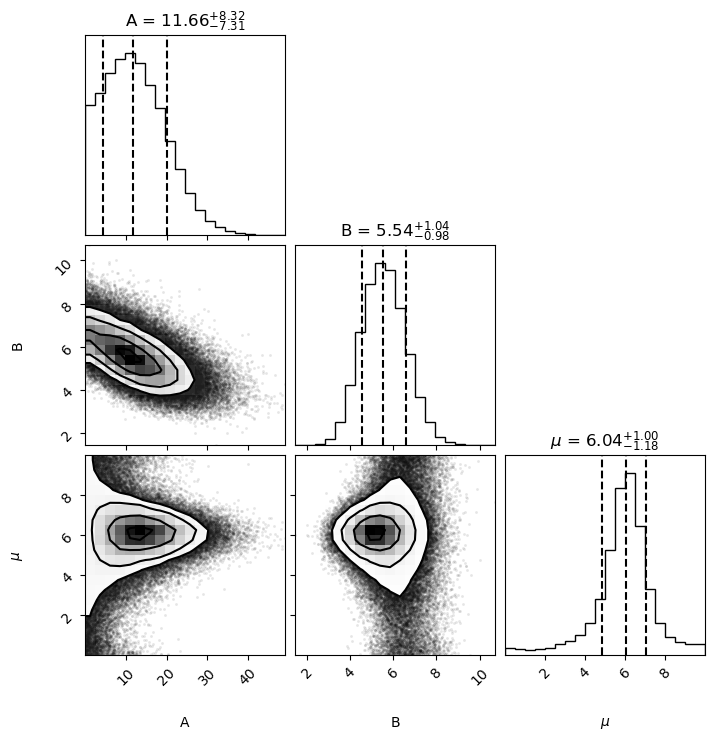

In [24]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

## 4c

In [9]:
def poisson_distribution_c(theta,xi,N_i):
    A,B,mu,sigma=theta
    K=N_i
    lam=lambda_i(A,B,xi,sigma,mu)
    return (lam**K)*np.exp(-lam)/sc.special.factorial(K)  # Use scipy's factorial for array support

def loglikelihood_c(theta,xi,N_i):
    A,B,mu,sigma=theta
    lam=lambda_i(A,B,xi,sigma,mu)
    return np.sum(sc.stats.poisson.logpmf(N_i, lam))


def log_prior_c(theta,xi,N_i):
    A,B,mu,sigma=theta
    if 0 < A < 50 and 0 < B < 50 and 3 < mu < 9 and 0 < sigma < 10:
        return 0.0
    return -np.inf

def log_probability_c(theta,xi,N_i):
    lp = log_prior_c(theta,xi,N_i)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood_c(theta,xi,N_i)
from multiprocessing import Pool

pos_c= np.array([20,6,6,2])+1e-1 * np.random.randn(128, 4)
nwalkers_c, ndim_c = pos_c.shape
with Pool() as pool:
    sampler_c = emcee.EnsembleSampler(nwalkers_c, ndim_c, log_probability_c, args=(xi,N_i),pool=pool)
    run_c=sampler_c.run_mcmc(pos_c, int(1e5), progress=True)


100%|██████████| 100000/100000 [22:02<00:00, 75.62it/s] 


In [10]:
import pickle

with open('sampler_c.pkl', 'wb') as f:
    pickle.dump(sampler_c, f)


Text(0.5, 0, 'step number')

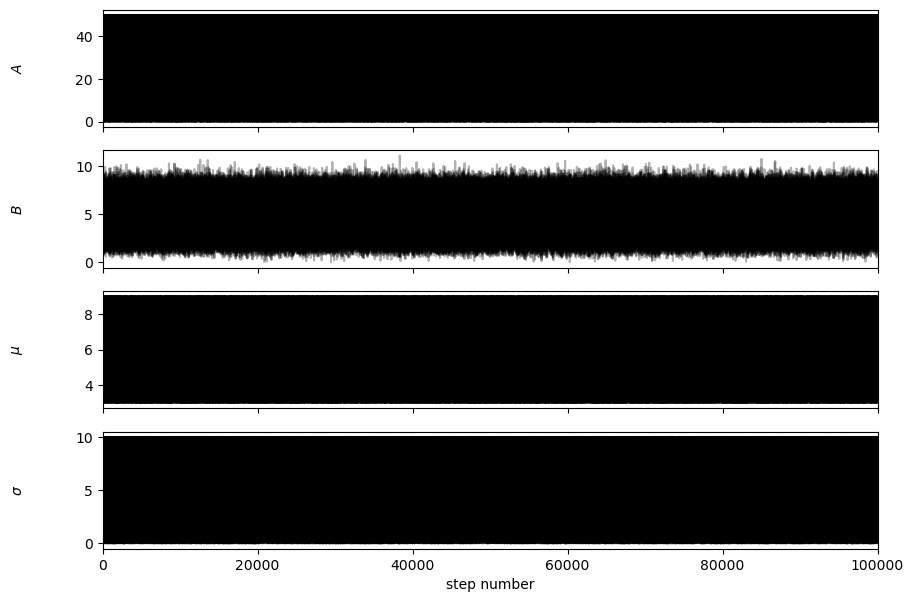

In [11]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_c = sampler_c.get_chain()
labels = [r"$A$", r"$B$", r"$\mu$", r"$\sigma$"]
for i in range(ndim_c):
    ax = axes[i]
    ax.plot(samples_c[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_c))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [12]:
tau_c = sampler_c.get_autocorr_time()
print(tau_c)

[ 87.29835294  84.99762277  89.2398008  103.29927264]


(1277440, 4)


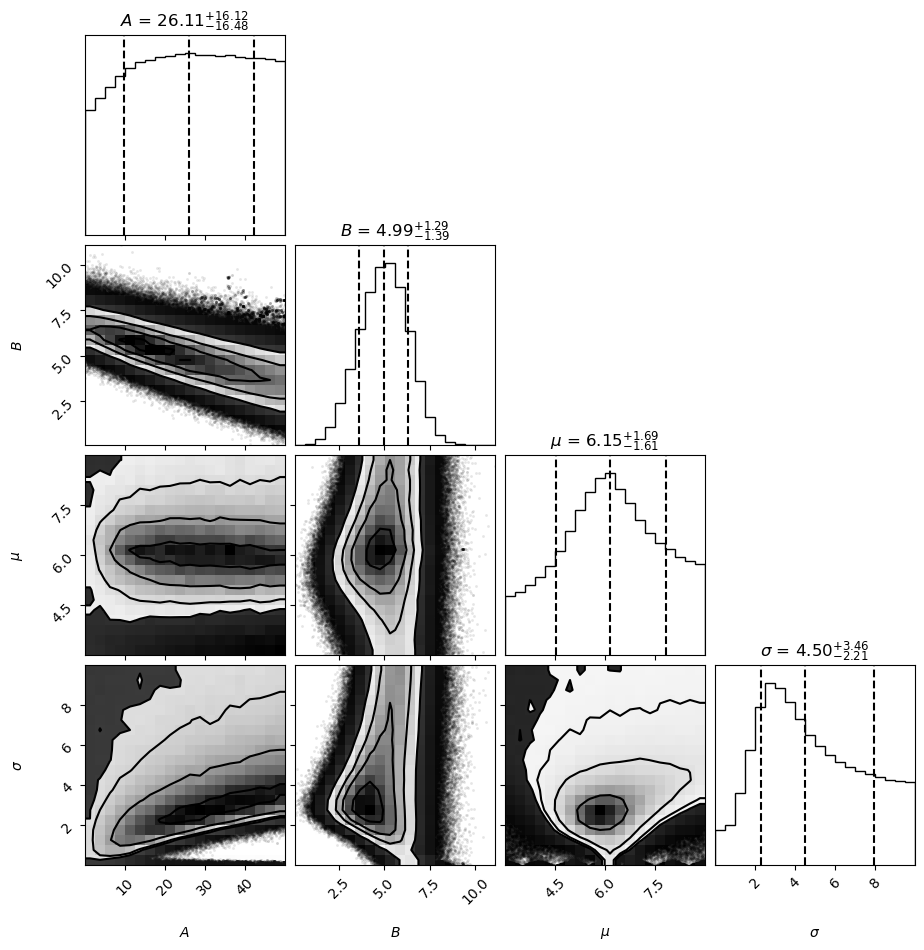

In [13]:
flat_samples_c = sampler_c.get_chain(discard=200, thin=10, flat=True)
print(flat_samples_c.shape)
fig = corner.corner(
    flat_samples_c, labels=labels,quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

## 4d